## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

### Setup

In [1]:
using GeneralizedPhaseReduction
using DifferentialEquations, PyPlot, PyCall, ProgressMeter, Random, LinearAlgebra
Random.seed!(10)
axes_grid1 = pyimport("mpl_toolkits.axes_grid1")

PyObject <module 'mpl_toolkits.axes_grid1' from 'C:\\ProgramData\\Miniconda3\\lib\\site-packages\\mpl_toolkits\\axes_grid1\\__init__.py'>

### Model definition

In [2]:
dxdt(X, I, λ=5.0) = λ*(X[1]-I) - exp(I)*X[2]-λ*((X[1]-I)^2+X[2]^2)*(X[1]-I)
dydt(X, I, λ=5.0) = exp(I)*(X[1]-I) + λ*X[2]-λ*((X[1]-I)^2+X[2]^2)*X[2]
F(X, I) = [dxdt(X, I), dydt(X, I)]

D, N = 2, 5 # number of dimensions, units
Nθ = 1000
W = rand(N, N)
W -= Diagonal(W)
W ./= sqrt.(sum(W.^2, dims=2)) # normalize
 
G(X, K) = K * (W * X[:, 1])
#G(X, K) = K * ((1 .- eye(N)) * X[:, 1])
dt = 1e-3; T = 15.0; Nt = round(Int, T/dt)
trange = range(0, T, length=Nt)
alg = Tsit5(); #Rosenbrock23() #Tsit5();

In [3]:
@time Ts, ω, Xs = find_stable_periodic_solution(F, 0, D, Nθ, [1, 0], dt, Tsit5(), 2, 0.0, print_progress=false)
println("Ts=", Ts, " (sec) , ω=", ω, " (Hz)")

 18.348468 seconds (47.33 M allocations: 4.842 GiB, 3.35% gc time, 98.66% compilation time)
Ts=6.284 (sec) , ω=0.9998703544206853 (Hz)


In [4]:
# F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr
ωI, ζθI, ξθI, XsI = generalized_phase_sensitivity_func(F, -2.5, 4, 0.1, D, Nθ, nothing, dt, Tsit5(), 2, 0.0);

[1/3] Computing Xs(θ, I) and Z(θ, I)... 100%|████████████| Time: 0:00:18


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


In [5]:
function coupled_func!(dX, X, p, t)
    g, κ = p
    Iext = g(X) # input
    for i in 1:size(dX)[1]
        dX[i, :] = κ[i] * F(X[i, :], Iext[i])
    end
end

coupled_func! (generic function with 1 method)

### Run simulation

In [6]:
K = 0.25
κ = ones(N) + 0.5*rand(N) #[1.0, 1.5]
initθ = rand(N)*2pi # collect(range(0, π, length=N))
NΘ = 100
input_mode = "I"; # "I" or "PQ"

In [7]:
initθ 

5-element Vector{Float64}:
 1.1933577567457754
 4.703582434554448
 4.777639213493416
 2.824656536714155
 4.568763890839031

In [8]:
g(X) = G(X, K)

g (generic function with 1 method)

In [9]:
Tos, Xos, Θgos, Θcos = coupled_original_system(N, D, T, XsI, g, coupled_func!, initθ, κ, alg);

In [10]:
size(Xos)

(4720, 5, 2)

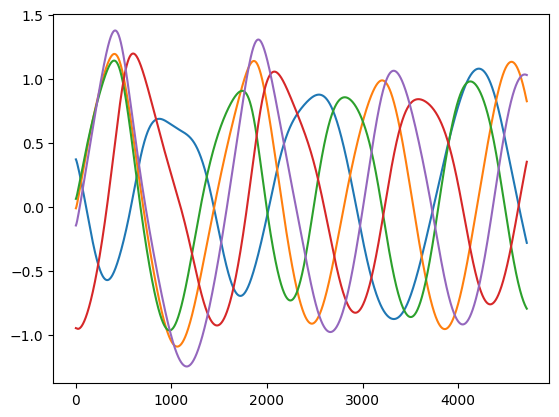

In [11]:
for i in 1:N
    plot(Xos[:, i, 1])
end

In [12]:
function compute_online_IsΘ(Θ::Vector{Float64}, G::Function, N::Int, D::Int, XsI;
        initIₜ=nothing, ttmax::Int=100, ϵ=1e-5)
    """
    Compute online I₀(θ)

    Args:
    - N :number of units
    - D : Dimension of states; (Int)

    Returns:
    - I₀(θ)   :  ∈ R^N
    """

    X = zeros(N, D)
    # initial I
    if initIₜ == nothing
        Iₜ = zeros(N)
    else
        Iₜ = initIₜ
    end

    for tt in 1:ttmax
        for i in 1:N
            X[i, :] = [XsI[j](Θ[i], Iₜ[i]) for j in 1:D]
        end

        Iₜ₋₁ = copy(Iₜ)
        Iₜ = G(X) # update

        if sum(abs.(Iₜ .- Iₜ₋₁)) <  ϵ # check convergence
            break
        end
    end
    return Iₜ # save
end

compute_online_IsΘ (generic function with 1 method)

In [13]:
compute_online_IsΘ(initθ, g, N, D, XsI)

5-element Vector{Float64}:
 -0.10794433199011111
 -0.11794710292207652
 -0.1765978667049145
 -0.050053964553162675
 -0.1528487716539782

In [14]:
function jacobian(func::Function, x::Vector{Float64}; ϵ::Float64=1e-6, periodic::Bool=true)
    N = size(x)[1]
    jac = zeros(N, N)
    for i in 1:N
        x1 = copy(x)
        x2 = copy(x)
        x1[i] += ϵ
        x2[i] -= ϵ
        if periodic
            jac[:, i] = (func(mod.(x1, 2π)) - func(mod.(x2, 2π)))/(2*ϵ)
        else
            jac[:, i] = (func(x1) - func(x2))/(2*ϵ)
        end
    end
    return jac
end

jacobian (generic function with 1 method)

In [15]:
params = (g, N, D, XsI);

In [16]:
input_func(θ) = compute_online_IsΘ(θ, params...)

input_func (generic function with 1 method)

In [17]:
jacobian(input_func, initθ)

5×5 Matrix{Float64}:
 -0.0611482  0.117546   0.27514   -0.0392114  0.190206
 -0.184423   0.0765843  0.147073  -0.054547   0.227517
 -0.171365   0.11558    0.112025  -0.0736617  0.180861
 -0.114417   0.210281   0.245017  -0.0277415  0.15645
 -0.0907572  0.199269   0.239778  -0.0620988  0.0851108

In [18]:
function online_generalized_coupled_updateΘ_I(Θ, p, t)
    N, κ, input_func, ωI, ξθI = p
    Θ = mod.(Θ, 2π) # θ ∈[0, 2π]
    IΘₜ = input_func(Θ)
    #println("I", IΘₜ, "Θ", Θ)
    ωΘ = [κ[i] * ωI(IΘₜ[i]) for i in 1:N]
    J = jacobian(input_func, Θ)
    XiΘ = LinearAlgebra.I　- hcat([ξθI(Θ[i], IΘₜ[i]) * J[i, :] for i in 1:N]...)'
    dΘ = XiΘ \ ωΘ # generalized phase equation
    return dΘ
end

online_generalized_coupled_updateΘ_I (generic function with 1 method)

In [19]:
# for adaptive time step
function online_coupled_generalized_phase_model_I(N::Int, D::Int, T::Float64, input_func, ωI, ξθI, initθ, κ, alg=Tsit5())
    sol = get_ode_solution(online_generalized_coupled_updateΘ_I, initθ, (0, T), nothing, (N, κ, input_func, ωI, ξθI), alg);
    println("Get solution!")
    Θ = hcat(sol.u...)';
    Nt = length(sol.u)
    X = zeros(Nt, N, D)
    for tt in 1:Nt
        IΘₜ = input_func(mod.(Θ[tt, :], 2π))
        for i in 1:N
            X[tt, i, :] = [XsI[j](mod(Θ[tt, i], 2π), IΘₜ[i]) for j in 1:D] # memory
        end
    end    
    return sol.t, X, Θ
end

online_coupled_generalized_phase_model_I (generic function with 2 methods)

In [20]:
function online_coupled_generalized_phase_model_I(N::Int, D::Int, Nt::Int, dt::Float64, XsI, input_func, ωI, ξθI, initθ, κ, alg=Tsit5())
    X = zeros(Nt, N, D) # states
    Θ = zeros(Nt, N)    # phase
    integrator = get_ode_integrator(online_generalized_coupled_updateΘ_I, initθ, dt, (N, κ, input_func, ωI, ξθI), alg)
    for tt in 1:Nt
        θ = mod.(copy(integrator.u), 2π)
        Θ[tt, :] = copy(integrator.u)
        IΘₜ = input_func(θ)
        for i in 1:N
            X[tt, i, :] = [XsI[j](θ[i], IΘₜ[i]) for j in 1:D]
        end
        step!(integrator, dt, true) # update
    end
    return X, Θ
end

online_coupled_generalized_phase_model_I (generic function with 4 methods)

In [21]:
#Xgpm, Θgpm = online_coupled_generalized_phase_model_I(N, D, Nt, dt, XsI, input_func, ωI, ξθI, Θgos[1, :], κ, alg);

In [22]:
Tgpm, Xgpm, Θgpm = online_coupled_generalized_phase_model_I(N, D, T, input_func, ωI, ξθI, Θgos[1, :], κ, alg);

Get solution!


In [23]:
size(Θgpm)

(3008, 5)

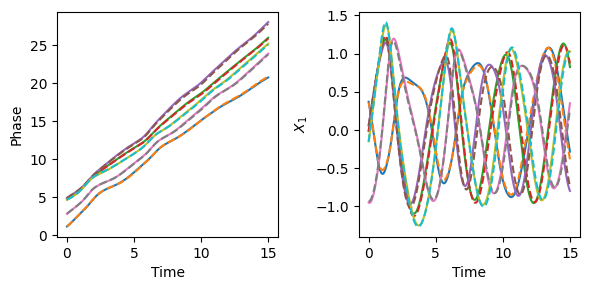

In [24]:
fig, ax = subplots(1, 2, figsize=(6,3), sharex="all")
for i in 1:N
    ax[1].plot(Tos, Θgos[:, i])
    #ax[1].plot(trange, Θgpm[:, i], "--")
    ax[1].plot(Tgpm, Θgpm[:, i], "--")
end
ax[1].set_ylabel("Phase")
ax[1].set_xlabel("Time")

for i in 1:N
    ax[2].plot(Tos, Xos[:, i, 1])
    #ax[2].plot(trange, Xgpm[:, i, 1], "--")
    ax[2].plot(Tgpm, Xgpm[:, i, 1], "--")
end
ax[2].set_ylabel(L"$X_1$")
ax[2].set_xlabel("Time")
tight_layout()

In [25]:
Tcpm, Xcpm, Θcpm = coupled_conventinal_phase_model(N, D, T, XsI, g, ωI, ζθI, Θcos[1, :], κ, alg);

In [26]:
cm = get_cmap(:tab20)

In [27]:
ωtos = [(k * ω) .* Tos for k in κ]
ωtcpm = [(k * ω) .* Tcpm for k in κ]
ωtgpm = [(k * ω) .* Tgpm for k in κ];

In [28]:
os_labels = append!(["original system"], [" " for _ in 1:N-1])
cpm_labels = append!(["phase eq. [conventional]"], [" " for _ in 1:N-1])
gpm_labels = append!(["phase eq. [proposed]"], [" " for _ in 1:N-1]);

In [29]:
panel_id = 'a':'d'

'a':1:'d'

In [30]:
plt.rc("text", usetex=true)
PyCall.PyDict(plt."rcParams")["font.size"] = 14
PyCall.PyDict(plt."rcParams")["xtick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["ytick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["xtick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["ytick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["xtick.top"] = true 
PyCall.PyDict(plt."rcParams")["ytick.right"] = true 
PyCall.PyDict(plt."rcParams")["font.family"] = "Arial"
PyCall.PyDict(plt."rcParams")["text.latex.preamble"] = [raw"\usepackage{amsmath}"];

sys:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


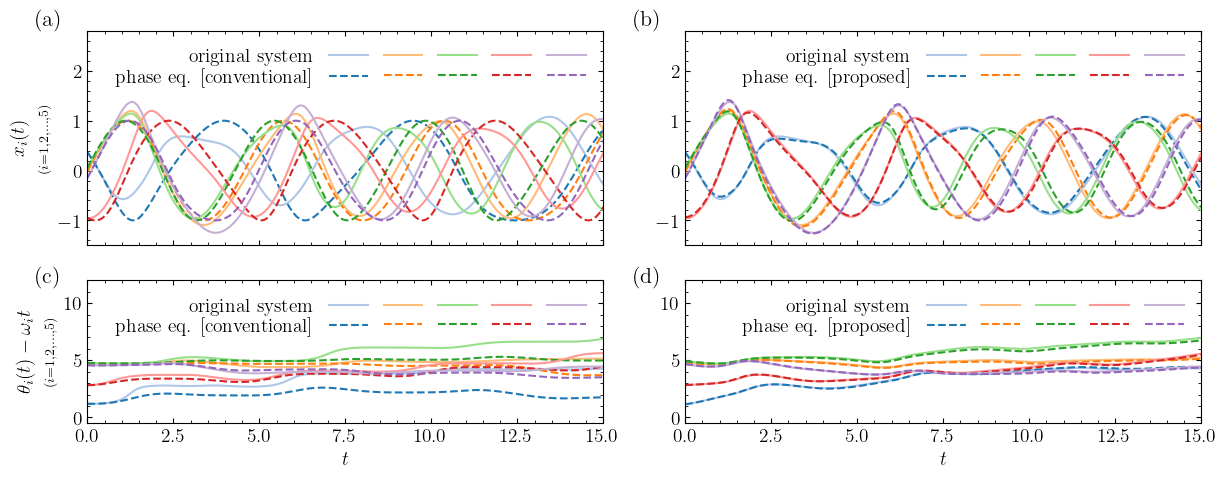

In [31]:
fig, ax = subplots(2,2, figsize=(12.5, 5), sharex="all", gridspec_kw=Dict("height_ratios" => [3,2]))
#ax[1, 1].set_title("Conventional")
#ax[1, 2].set_title("Generalized")
for i in 1:N
    ax[1, 1].plot(Tos, Xos[:, i, 1], color=cm((i-1)*2+1), label=os_labels[i])
    ax[1, 1].plot(Tcpm, Xcpm[:, i, 1], "--", color=cm((i-1)*2), label=cpm_labels[i])
    ax[1, 2].plot(Tos, Xos[:, i, 1], color=cm((i-1)*2+1), label=os_labels[i])
    ax[1, 2].plot(Tgpm, Xgpm[:, i, 1], "--", color=cm((i-1)*2), label=gpm_labels[i])
    ax[2, 1].plot(Tos, Θcos[:, i] - ωtos[i], color=cm((i-1)*2+1), label=os_labels[i])
    ax[2, 1].plot(Tcpm, Θcpm[:, i] - ωtcpm[i], "--", color=cm((i-1)*2), label=cpm_labels[i])
    ax[2, 2].plot(Tos, Θgos[:, i] - ωtos[i], color=cm((i-1)*2+1), label=os_labels[i])
    ax[2, 2].plot(Tgpm, Θgpm[:, i] - ωtgpm[i], "--", color=cm((i-1)*2), label=gpm_labels[i])
end

ax[1, 1].set_ylabel(L"$x_i(t)$"*"\n"*L"$_{(i=1,2,\ldots,5)}$")
ax[2, 1].set_ylabel(L"$\theta_i(t)-\omega_i t$"*"\n"*L"$_{(i=1,2,\ldots,5)}$"); 
for i in 1:2
    ax[i, 1].set_xlim(0, T)
    ax[2, i].set_xlabel(L"$t$")
end
for i in 1:2
    for j in 1:2
        ax[i, j].legend(loc="upper right", ncol=5, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)
        ax[i, j].text(-0.1, 1.1, "("*panel_id[j+(i-1)*2]*")", fontsize=16, transform=ax[i, j].transAxes, fontweight="bold", va="top")
    end
end
ax[1,1].set_ylim(-1.5, 2.8)
ax[1,2].set_ylim(-1.5, 2.8)
ax[2,1].set_ylim(-0.5, 12)
ax[2,2].set_ylim(-0.5, 12)
ax[2,1].set_xticks(collect(0:2.5:15))

fig.tight_layout()
fig.savefig("fig4.svg")